In [1]:
!pip install keras-tuner

from kerastuner import RandomSearch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.2 MB/s eta 0:00:00


<ipython-input-1-8e34657b3db0>:3: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner import RandomSearch


In [2]:
from google.colab import files
import pandas as pd

# Upload the files to the Colab environment
uploaded = files.upload()

# Read the Excel files into pandas DataFrames
gene_data = pd.read_excel('Combined_Gene_CDS.xlsx')
phenotype_data = pd.read_excel('Combined_phenotypes.xlsx')

# Display the first few rows of each dataframe
print("Gene Data:")
print(gene_data.head())
print("\nPhenotype Data:")
print(phenotype_data.head())


Saving Combined_Gene_CDS.xlsx to Combined_Gene_CDS.xlsx
Saving Combined_phenotypes.xlsx to Combined_phenotypes.xlsx
Gene Data:
      Gene           Phenotype Activity Score EHR Priority Result Notation  \
0  SLCO1B1  Decreased Function            NaN  Abnormal/Priority/High Risk   
1  SLCO1B1  Increased Function            NaN      Normal/Routine/Low Risk   
2  SLCO1B1       Indeterminate            NaN                         none   
3  SLCO1B1     Normal Function            NaN      Normal/Routine/Low Risk   
4  SLCO1B1       Poor Function            NaN  Abnormal/Priority/High Risk   

                                   Consultation Text  
0  This result signifies that the patient has one...  
1  This result signifies that the patient has two...  
2  This result signifies that the patient has an ...  
3  This result signifies that the patient has two...  
4  This result signifies that the patient has two...  

Phenotype Data:
    Allele 1 Function   Allele 2 Function Activity Value 

In [3]:

# Combine the datasets on the 'Gene' column
combined_data = pd.merge(gene_data, phenotype_data, on='Gene')

# Display the first few rows of the combined dataframe
print("Combined Data:")
print(combined_data.head())

Combined Data:
      Gene         Phenotype_x Activity Score_x EHR Priority Result Notation  \
0  SLCO1B1  Decreased Function              NaN  Abnormal/Priority/High Risk   
1  SLCO1B1  Decreased Function              NaN  Abnormal/Priority/High Risk   
2  SLCO1B1  Decreased Function              NaN  Abnormal/Priority/High Risk   
3  SLCO1B1  Decreased Function              NaN  Abnormal/Priority/High Risk   
4  SLCO1B1  Decreased Function              NaN  Abnormal/Priority/High Risk   

                                   Consultation Text   Allele 1 Function  \
0  This result signifies that the patient has one...  Uncertain function   
1  This result signifies that the patient has one...    Unknown function   
2  This result signifies that the patient has one...         No function   
3  This result signifies that the patient has one...  Increased function   
4  This result signifies that the patient has one...     Normal function   

  Allele 2 Function Activity Value Allele 1 Act

In [4]:
# Print column names to check for correct target column
print("Columns in combined data:")
print(combined_data.columns)


Columns in combined data:
Index(['Gene', 'Phenotype_x', 'Activity Score_x',
       'EHR Priority Result Notation', 'Consultation Text',
       'Allele 1 Function', 'Allele 2 Function', 'Activity Value Allele 1',
       'Activity Value Allele 2', 'Activity Score_y', 'Phenotype_y',
       'Description'],
      dtype='object')


In [5]:
# Use the correct column name for the target variable
target_column = 'Phenotype_y'

# Separate features and target variable
X = combined_data.drop(target_column, axis=1)
y = combined_data[target_column]


In [6]:
from sklearn.preprocessing import LabelEncoder

# Initialize LabelEncoders for all object type columns
label_encoders = {}
for column in X.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    X[column] = le.fit_transform(X[column])
    label_encoders[column] = le

# Encode the target variable
target_encoder = LabelEncoder()
y = target_encoder.fit_transform(y)


In [7]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Normalize the feature data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Build and train the model
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Define the model
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(len(target_encoder.classes_), activation='softmax')  # For multi-class classification
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_accuracy}')


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.2246 - loss: 2.7676 - val_accuracy: 0.6562 - val_loss: 1.8932
Epoch 2/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5543 - loss: 1.8310 - val_accuracy: 0.7292 - val_loss: 1.1090
Epoch 3/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6088 - loss: 1.3396 - val_accuracy: 0.7708 - val_loss: 0.8405
Epoch 4/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7380 - loss: 0.9479 - val_accuracy: 0.7500 - val_loss: 0.7304
Epoch 5/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7344 - loss: 0.8618 - val_accuracy: 0.7812 - val_loss: 0.6433
Epoch 6/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7817 - loss: 0.7151 - val_accuracy: 0.7552 - val_loss: 0.5881
Epoch 7/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7829 - loss: 0.6590 - val_accuracy: 0.8333 - val_loss: 0.5329
Epoch 8/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7863 - loss: 0.6574 - val_accuracy: 0.8177 - val_los

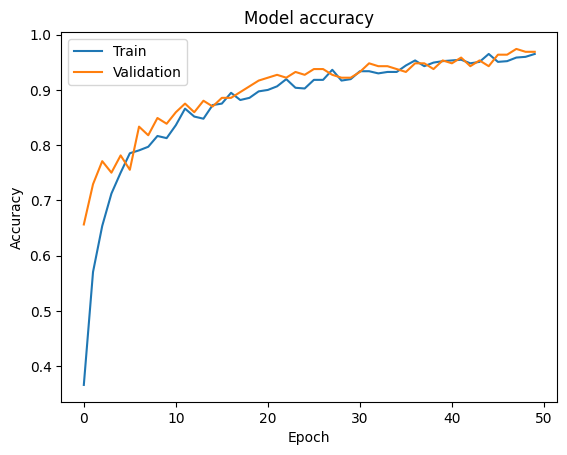

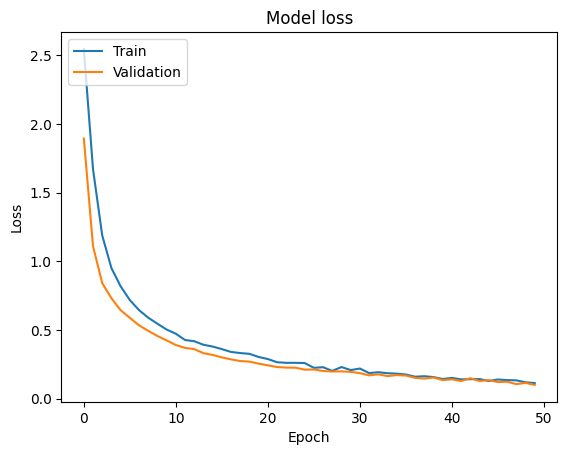

In [8]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [9]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

# Predict on the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Get unique classes from true labels and predicted labels
unique_true_classes = np.unique(y_test)
unique_pred_classes = np.unique(y_pred_classes)

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes, labels=unique_true_classes)

print("Confusion Matrix:")
print(conf_matrix)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
Confusion Matrix:
[[ 6  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 3  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  4  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  3  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0 73  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0 43  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 31  0  1  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  5  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0 46  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  4  0  0  1]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  9  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  2  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1]]


In [10]:


# Convert unique class indices to actual class names using target encoder
actual_target_names = target_encoder.inverse_transform(unique_true_classes)

# Ensure all target names are strings
actual_target_names = [str(name) for name in actual_target_names]

# Generate the classification report using the correct labels and target names
class_report = classification_report(
    y_test, y_pred_classes, labels=unique_true_classes, target_names=actual_target_names
)
print("\nClassification Report:")
print(class_report)



Classification Report:
                                         precision    recall  f1-score   support

                  CYP2C19 Indeterminate       0.67      1.00      0.80         6
       CYP2C19 Intermediate Metabolizer       1.00      0.40      0.57         5
CYP2C19 Likely Intermediate Metabolizer       1.00      0.80      0.89         5
        CYP2C19 Likely Poor Metabolizer       1.00      1.00      1.00         3
             CYP2C19 Normal Metabolizer       1.00      1.00      1.00         3
               CYP2C19 Poor Metabolizer       1.00      1.00      1.00         1
         CYP2C19 Ultrarapid Metabolizer       1.00      1.00      1.00         1
                   CYP2D6 Indeterminate       1.00      1.00      1.00        73
        CYP2D6 Intermediate Metabolizer       1.00      1.00      1.00        43
              CYP2D6 Normal Metabolizer       1.00      0.97      0.98        32
                CYP2D6 Poor Metabolizer       1.00      1.00      1.00         5
   

In [11]:


# Define a function to build the model with different hyperparameters
def build_model(hp):
    model = Sequential()
    model.add(Dense(units=hp.Int('units', min_value=32, max_value=512, step=32),
                    activation='relu', input_shape=(X_train.shape[1],)))
    model.add(Dropout(hp.Float('dropout', min_value=0.0, max_value=0.5, step=0.1)))
    model.add(Dense(len(target_encoder.classes_), activation='softmax'))

    model.compile(optimizer=hp.Choice('optimizer', ['adam', 'rmsprop']),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Perform hyperparameter search
tuner = RandomSearch(build_model,
                     objective='val_accuracy',
                     max_trials=10,
                     executions_per_trial=2,
                     directory='my_dir',
                     project_name='hyperparam_tuning')

tuner.search(X_train, y_train, epochs=50, validation_split=0.2)
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Print best hyperparameters
print(f"The best number of units is {best_hps.get('units')}")
print(f"The best dropout rate is {best_hps.get('dropout')}")
print(f"The best optimizer is {best_hps.get('optimizer')}")


Trial 10 Complete [00h 00m 22s]
val_accuracy: 0.9713541865348816

Best val_accuracy So Far: 0.9869791567325592
Total elapsed time: 00h 03m 33s
The best number of units is 416
The best dropout rate is 0.1
The best optimizer is rmsprop


In [18]:
from tensorflow.keras.layers import Input

def create_model():
    model = Sequential()
    model.add(Input(shape=(X_train.shape[1],)))  # Use Input layer for defining input shape
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(len(target_encoder.classes_), activation='softmax'))
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model



In [21]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import cross_val_score

class CustomKerasClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, build_fn=None, epochs=1, batch_size=32, verbose=0, **kwargs):
        self.build_fn = build_fn
        self.epochs = epochs
        self.batch_size = batch_size
        self.verbose = verbose
        self.kwargs = kwargs
        self.model_ = None

    def fit(self, X, y, **kwargs):
        self.model_ = self.build_fn()
        self.model_.fit(X, y, epochs=self.epochs, batch_size=self.batch_size, verbose=self.verbose, **kwargs)
        return self

    def predict(self, X, **kwargs):
        return np.argmax(self.model_.predict(X), axis=-1)

    def score(self, X, y, **kwargs):
        return self.model_.evaluate(X, y, verbose=self.verbose, **kwargs)[1]

# Re-instantiate and use the custom classifier
model = CustomKerasClassifier(build_fn=create_model, epochs=50, batch_size=32, verbose=0)

# Run cross-validation
scores = cross_val_score(model, X_scaled, y, cv=5)

print(f"Cross-Validation Accuracy: {scores.mean()} ± {scores.std()}")


Cross-Validation Accuracy: 0.9675000071525574 ± 0.05286250203362357


In [22]:
# Define the model with the best hyperparameters
best_model = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(units=best_hps.get('units'), activation='relu'),
    Dropout(best_hps.get('dropout')),
    Dense(len(target_encoder.classes_), activation='softmax')
])

# Compile the model
best_model.compile(optimizer=best_hps.get('optimizer'),
                   loss='sparse_categorical_crossentropy',
                   metrics=['accuracy'])

# Train the model
best_model.fit(X_scaled, y, epochs=50, batch_size=32, validation_split=0.2)

# Evaluate the model
test_loss, test_accuracy = best_model.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_accuracy}')

# Save the model in the new format
best_model.save("final_model.keras")


Epoch 1/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.4465 - loss: 2.3318 - val_accuracy: 0.7792 - val_loss: 1.2175
Epoch 2/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7301 - loss: 1.1379 - val_accuracy: 0.8125 - val_loss: 0.7229
Epoch 3/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7424 - loss: 0.8909 - val_accuracy: 0.8458 - val_loss: 0.5076
Epoch 4/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7991 - loss: 0.6643 - val_accuracy: 0.8542 - val_loss: 0.4102
Epoch 5/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8034 - loss: 0.5878 - val_accuracy: 0.8958 - val_loss: 0.3409
Epoch 6/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8325 - loss: 0.4723 - val_accuracy: 0.9250 - val_loss: 0.2938
Epoch 7/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8574 - loss: 0.4379 - val_accuracy: 0.9167 - val_loss: 0.2691
Epoch 8/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8696 - loss: 0.3602 - val_accuracy: 0.9333 - val_loss